# VIX modelling using both RNN/LSTM as well as SARIMAX models

$Background$ <br>
VIX, or the CBOE Volatility Index, is a **measure of the market's expectation of volatility over the next 30 days**. It's often referred to as the "fear index" because it tends to spike when there is market turmoil or uncertainty.

The VIX is calculated by the Chicago Board Options Exchange (CBOE) based on the prices of options contracts on the S&P 500 index. These contracts are used by investors to protect against market swings or to speculate on market movements. The VIX is calculated using a formula that takes into account the prices of a wide range of options with different expiration dates and strike prices.

A high VIX value indicates that the market expects high volatility, while a low VIX value indicates that the market expects low volatility. The VIX is often used as a barometer of market sentiment and is closely watched by traders and investors. It can be used to gauge the level of risk in the market and to inform investment decisions.

In this project, we will be modelling the VIX level using past VIX levels, past S&P 500 volume as well as S&P 500 returns. We will fit both a RNN, LSTM as well as a SARIMAX model as a baseline for comparison. We will compare the measure of fit on the test data.

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.stattools import acf, pacf, coint
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from matplotlib.pyplot import figure

In [2]:
end = dt.datetime.now()
start = dt.datetime(2010,1,1)
df1 = pd.DataFrame(yf.download('^GSPC', start=start, end=end))
df2 = pd.DataFrame(yf.download('^VIX', start=start, end=end))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
df1.columns = 'GSPC_' + df1.columns
df2.columns = 'VIX_' + df2.columns

In [5]:
df1

,GSPC_Open,GSPC_High,GSPC_Low,GSPC_Close,GSPC_Adj Close,GSPC_Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2024-04-15,5149.669922,5168.430176,5052.470215,5061.819824,5061.819824,3950210000
2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,5051.410156,4006200000
2024-04-17,5068.970215,5077.959961,5007.250000,5022.209961,5022.209961,3596130000


In [4]:
df2

,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,VIX_Volume
Date,,,,,,
2010-01-04,21.680000,21.680000,20.030001,20.040001,20.040001,0
2010-01-05,20.049999,20.129999,19.340000,19.350000,19.350000,0
2010-01-06,19.590000,19.680000,18.770000,19.160000,19.160000,0
2010-01-07,19.680000,19.709999,18.700001,19.059999,19.059999,0
2010-01-08,19.270000,19.270000,18.110001,18.129999,18.129999,0
...,...,...,...,...,...,...
2024-04-15,16.940001,19.459999,16.260000,19.230000,19.230000,0
2024-04-16,19.490000,19.559999,17.639999,18.400000,18.400000,0
2024-04-17,18.240000,19.110001,17.540001,18.209999,18.209999,0


In [6]:
df = df1[['GSPC_Close', 'GSPC_Volume']].join(df2['VIX_Close'])

In [7]:
df['GSPC_Log_Ret'] = np.log(1 + df['GSPC_Close'].pct_change())

In [8]:
df['GSPC_Log_Vol'] = np.log(df['GSPC_Log_Ret'].rolling(window=20).std()*np.sqrt(252)*100)

In [9]:
df['VIX_Log'] = np.log(df['VIX_Close'])

In [10]:
df['GSPC_Log_Volume'] = np.log(df['GSPC_Volume'])

In [19]:
df.agg(
    {
        "GSPC_Volume": ["min", "max", "median", "skew"],
        "VIX_Close": ["min", "max", "median", "mean"],
    }
)

,GSPC_Volume,VIX_Close
min,1.025000e+09,9.140000
max,1.061781e+10,82.690002
median,3.787685e+09,16.690001
skew,1.521843e+00,NaN
mean,NaN,18.482952


Note: We take log of the variables to get rid of the skewness in the samples

In [11]:
df_new = df[['GSPC_Log_Ret','VIX_Log','GSPC_Log_Volume']].dropna()

In [118]:
X = pd.DataFrame(StandardScaler(
    with_mean=True ,
    with_std=True).fit_transform(df_new),
                 columns=df_new.columns,
                 index=df_new.index)

In [119]:
cols = X.columns

for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col , lag), newcol)
X['train'] = (X.index < dt.datetime(2020,1,1))
X = X.dropna()

In [120]:
X.columns

Index(['GSPC_Log_Ret', 'VIX_Log', 'GSPC_Log_Volume', 'GSPC_Log_Ret_1',
       'VIX_Log_1', 'GSPC_Log_Volume_1', 'GSPC_Log_Ret_2', 'VIX_Log_2',
       'GSPC_Log_Volume_2', 'GSPC_Log_Ret_3', 'VIX_Log_3', 'GSPC_Log_Volume_3',
       'GSPC_Log_Ret_4', 'VIX_Log_4', 'GSPC_Log_Volume_4', 'GSPC_Log_Ret_5',
       'VIX_Log_5', 'GSPC_Log_Volume_5', 'train'],
      dtype='object')

In [121]:
X

,GSPC_Log_Ret,VIX_Log,GSPC_Log_Volume,GSPC_Log_Ret_1,VIX_Log_1,GSPC_Log_Volume_1,GSPC_Log_Ret_2,VIX_Log_2,GSPC_Log_Volume_2,GSPC_Log_Ret_3,VIX_Log_3,GSPC_Log_Volume_3,GSPC_Log_Ret_4,VIX_Log_4,GSPC_Log_Volume_4,GSPC_Log_Ret_5,VIX_Log_5,GSPC_Log_Volume_5,train
Date,,,,,,,,,,,,,,,,,,,
2010-01-12,-0.894323,0.137540,0.892456,0.121318,0.017084,0.447475,0.224272,0.117222,0.581587,0.325705,0.271289,1.374033,0.012226,0.287405,1.121885,0.245479,0.317796,-1.872745,True
2010-01-13,0.716502,0.069286,0.359638,-0.894323,0.137540,0.892456,0.121318,0.017084,0.447475,0.224272,0.117222,0.581587,0.325705,0.271289,1.374033,0.012226,0.287405,1.121885,True
2010-01-14,0.182985,0.031091,0.086126,0.716502,0.069286,0.359638,-0.894323,0.137540,0.892456,0.121318,0.017084,0.447475,0.224272,0.117222,0.581587,0.325705,0.271289,1.374033,True
2010-01-15,-1.026765,0.079621,0.931384,0.182985,0.031091,0.086126,0.716502,0.069286,0.359638,-0.894323,0.137540,0.892456,0.121318,0.017084,0.447475,0.224272,0.117222,0.581587,True
2010-01-19,1.092066,0.022344,0.900412,-1.026765,0.079621,0.931384,0.182985,0.031091,0.086126,0.716502,0.069286,0.359638,-0.894323,0.137540,0.892456,0.121318,0.017084,0.447475,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15,-1.136966,0.298637,0.124692,-1.370030,-0.025325,0.138936,0.637017,-0.485000,-0.387925,-0.901282,-0.306437,0.008793,0.093971,-0.470574,-0.524230,-0.071427,-0.427699,-0.683163,False
2024-04-16,-0.224530,0.162751,0.185664,-1.136966,0.298637,0.124692,-1.370030,-0.025325,0.138936,0.637017,-0.485000,-0.387925,-0.901282,-0.306437,0.008793,0.093971,-0.470574,-0.524230,False
2024-04-17,-0.564458,0.130782,-0.282139,-0.224530,0.162751,0.185664,-1.136966,0.298637,0.124692,-1.370030,-0.025325,0.138936,0.637017,-0.485000,-0.387925,-0.901282,-0.306437,0.008793,False


In [122]:
cols = ['GSPC_Log_Ret','VIX_Log','GSPC_Log_Volume']

Y, train = X['VIX_Log'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['GSPC_Log_Ret_1', 'VIX_Log_1', 'GSPC_Log_Volume_1', 'GSPC_Log_Ret_2',
       'VIX_Log_2', 'GSPC_Log_Volume_2', 'GSPC_Log_Ret_3', 'VIX_Log_3',
       'GSPC_Log_Volume_3', 'GSPC_Log_Ret_4', 'VIX_Log_4', 'GSPC_Log_Volume_4',
       'GSPC_Log_Ret_5', 'VIX_Log_5', 'GSPC_Log_Volume_5'],
      dtype='object')

In [123]:
X.shape

(3592, 15)

## RNN Data Processing

In [124]:
#Reorder the columns because input into RNN needs to have the earliest time first
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col , lag))
X_rnn = X.reindex(columns=ordered_cols)

In [125]:
X_rnn.columns

Index(['GSPC_Log_Ret_5', 'VIX_Log_5', 'GSPC_Log_Volume_5', 'GSPC_Log_Ret_4',
       'VIX_Log_4', 'GSPC_Log_Volume_4', 'GSPC_Log_Ret_3', 'VIX_Log_3',
       'GSPC_Log_Volume_3', 'GSPC_Log_Ret_2', 'VIX_Log_2', 'GSPC_Log_Volume_2',
       'GSPC_Log_Ret_1', 'VIX_Log_1', 'GSPC_Log_Volume_1'],
      dtype='object')

In [126]:
X_rnn = X_rnn.to_numpy().reshape((-1,5,3))
X_rnn.shape

(3592, 5, 3)

### Set up 1 Layer RNN model and LSTM model

We will be using the ISLP package along with pytorch_lightning package

In [127]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchsummary import summary
from torch.optim import RMSprop
from torchmetrics import (MeanAbsoluteError , R2Score)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

from ISLP.torch import (SimpleDataModule ,
    SimpleModule ,
    ErrorTracker ,
    rec_num_workers)

class VIXRNNModel(nn.Module):
    def __init__(self):
        super(VIXRNNModel , self).__init__()
        self.rnn = nn.RNN(3, 12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self , x):
        x , h_n = self.rnn(x)
        x = self.dropout(x[:,-1])
        x = self.dense(x)
        return torch.flatten(x)

class VIXLSTMModel(nn.Module):
    def __init__(self):
        super(VIXLSTMModel , self).__init__()
        self.rnn = nn.LSTM(3, 12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self , x):
        x , h_n = self.rnn(x)
        x = self.dropout(x[:,-1])
        x = self.dense(x)
        return torch.flatten(x)

vixrnn = VIXRNNModel()
vixlstm = VIXLSTMModel()

In [128]:
#Testing
vixrnn(torch.ones((5,5,3)))
vixlstm(torch.ones((5,5,3)))

tensor([-0.1436, -0.0913, -0.1155, -0.1205, -0.1118], grad_fn=<ViewBackward0>)

In [129]:
#Prepare train test dataset
# The train dataset will consist of data from 2010-2020 and the test from 2020-2024
datasets = []
for mask in [train , ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t , Y_t))
vix_train , vix_test = datasets

In [130]:
len(vix_train), len(vix_test)

(2510, 1082)

In [131]:
vix_dm = SimpleDataModule(vix_train ,
                           vix_test ,
                           num_workers=4,
                           validation=vix_test ,
                           batch_size =32)

### Test the RNN Model

In [134]:
vix_optimizer = RMSprop(vixrnn.parameters(),
                         lr=0.001)

vix_module = SimpleModule.regression(vixrnn,
                                      optimizer=vix_optimizer,
                                      metrics={'r2':R2Score(),
                                              'mae':MeanAbsoluteError()})

vix_trainer = Trainer(deterministic=True ,
                       max_epochs=100,
                       callbacks=[ErrorTracker()])

vix_trainer.fit(vix_module ,
                 datamodule=vix_dm)

vix_trainer.test(vix_module ,
                  datamodule=vix_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | VIXRNNModel | 217   
1 | loss  | MSELoss     | 0     
--------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.0716824159026146     │
│         test_mae          │    0.17503145337104797    │
│          test_r2          │    0.9269933700561523     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0716824159026146,
  'test_r2': 0.9269933700561523,
  'test_mae': 0.17503145337104797}]

In [144]:
X_test = torch.tensor(X_rnn[~train].astype(np.float32))


y_pred = vixrnn(X_test)

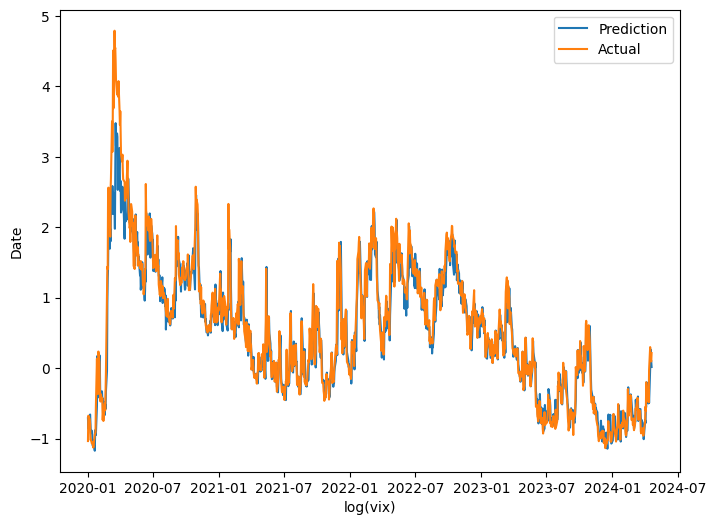

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
idx = X[~train].index
Y_test = Y[~train]
#y_pred = y_pred.detach().numpy()
#print(idx)
ax.plot(idx,y_pred,label = 'Prediction')
ax.plot(idx,Y_test,label = 'Actual')
ax.set_ylabel("Date")
ax.set_xlabel("log(vix)")
ax.legend()

### Test the LSTM Model

In [154]:
vix_optimizer = RMSprop(vixlstm.parameters(),
                         lr=0.001)

vix_module = SimpleModule.regression(vixlstm,
                                      optimizer=vix_optimizer,
                                      metrics={'r2':R2Score(),
                                              'mae':MeanAbsoluteError()})

vix_trainer = Trainer(deterministic=True ,
                       max_epochs=100,
                       callbacks=[ErrorTracker()])

vix_trainer.fit(vix_module ,
                 datamodule=vix_dm)

vix_trainer.test(vix_module ,
                  datamodule=vix_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | VIXLSTMModel | 829   
1 | loss  | MSELoss      | 0     
---------------------------------------
829       Trainable params
0         Non-trainable params
829       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.06951913982629776    │
│         test_mae          │    0.17518849670886993    │
│          test_r2          │    0.9291965961456299     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06951913982629776,
  'test_r2': 0.9291965961456299,
  'test_mae': 0.17518849670886993}]

In [157]:
X_test = torch.tensor(X_rnn[~train].astype(np.float32))

y_pred = vixlstm(X_test)

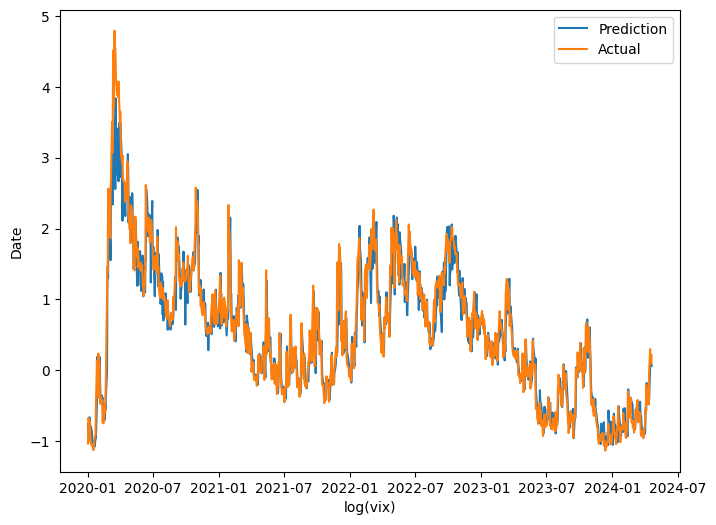

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
idx = X[~train].index
Y_test = Y[~train]
y_pred = y_pred.detach().numpy()
#print(idx)
ax.plot(idx,y_pred,label = 'Prediction')
ax.plot(idx,Y_test,label = 'Actual')
ax.set_ylabel("Date")
ax.set_xlabel("log(vix)")
ax.legend()

### Analysis

The models were trained using data from 2010-2020 and tested on data from 2020-2024.
Using a RNN and LSTM Model, we achieved a $R^2$ score of 0.9269 and 0.9292 on the test data respectively. Hence. both models were able to explain at least 90% of the variation in the data. We also observed that the LSTM slightly outperform the RNN model.

## SARIMAX Models

In [165]:
X.shape, Y.shape, train #mask

((3592, 15), (3592,), (3592,))

<Figure size 600x400 with 0 Axes>

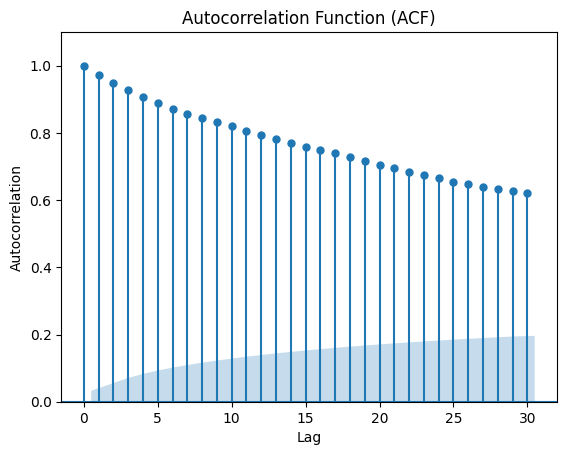

In [174]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(6, 4))
plot_acf(Y, lags=30)  # Specify the number of lags for the ACF plot
plt.ylim(0,1.1)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

<Figure size 600x400 with 0 Axes>

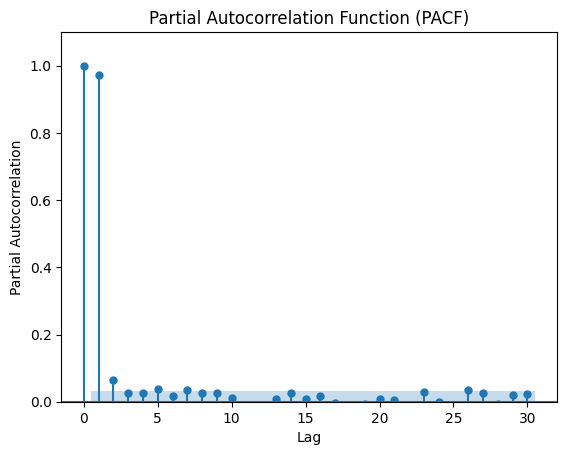

In [175]:
plt.figure(figsize=(6, 4))
plot_pacf(Y, lags=30)  # Specify the number of lags for the ACF plot
plt.ylim(0,1.1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

One way to identify whether the order of the ARMA model to use the PACF and ACF plot and identify the cutoffs within the plot. <br>
Hence, we can try to model log VIX values using AR(2) model to begin with since the cutoff is obvious in the PACF plot.

### ARMA(2,0) Model

In [214]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [213]:
#Y_train = Y[train]

model = ARIMA(Y, order=(2, 0, 0))
AR2 = model.fit()
AR2.summary()

C:\Users\ojw_m\anaconda3\New\envs\machine-learning-book\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ojw_m\anaconda3\New\envs\machine-learning-book\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ojw_m\anaconda3\New\envs\machine-learning-book\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                VIX_Log   No. Observations:                 3592
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 118.933
Date:                Mon, 22 Apr 2024   AIC                           -229.867
Time:                        13:38:39   BIC                           -205.121
Sample:                             0   HQIC                          -221.047
                               - 3592                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.172     -0.002      0.999      -0.338       0.337
ar.L1          0.9097      0.011     79.272      0.000       0.887       0.932
ar.L2          0.0643      0.011      5.666      0.000       0.042       0.087
sigma2         0.0548      0.001     79.345      0.000       0.053       0.056
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8296.67
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.31
Prob(H) (two-sided):                  0.07   Kurtosis:                         9.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [215]:
R2 = r2_score(Y,AR2.fittedvalues)
print("R-squared (R2) value:", R2)

R-squared (R2) value: 0.9453131896027515


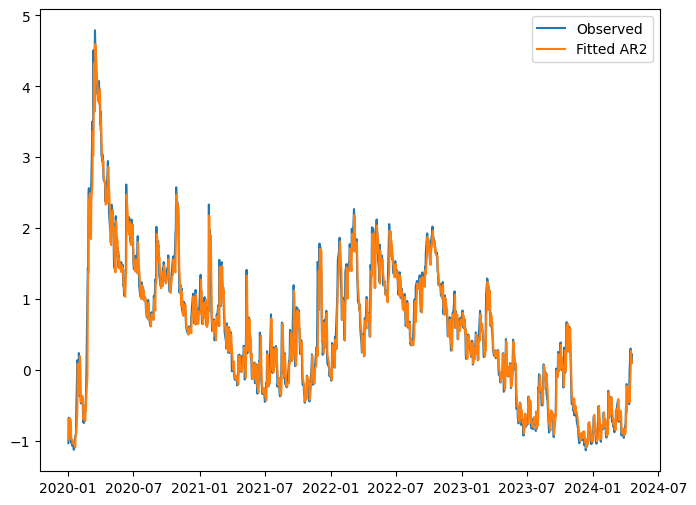

In [223]:
figure(figsize=(8, 6))
Y_test = Y[~train]
#print(Y_test)
plt.plot(Y_test, label='Observed')
plt.plot(idx, AR2.fittedvalues[~train],label='Fitted AR2')
plt.legend()
plt.show()

### ARMAX(2,0) Model with Log Return of SP500

In [211]:
exog = df_new['GSPC_Log_Ret'][5:]

model1 = ARIMA(Y, order=(2, 0, 0),exog = exog)
ARMAX = model1.fit()
ARMAX.summary()

C:\Users\ojw_m\anaconda3\New\envs\machine-learning-book\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ojw_m\anaconda3\New\envs\machine-learning-book\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ojw_m\anaconda3\New\envs\machine-learning-book\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                VIX_Log   No. Observations:                 3592
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 816.421
Date:                Mon, 22 Apr 2024   AIC                          -1622.841
Time:                        13:33:59   BIC                          -1591.909
Sample:                             0   HQIC                         -1611.816
                               - 3592                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0052      0.171      0.030      0.976      -0.330       0.340
GSPC_Log_Ret    -8.0056      0.083    -96.644      0.000      -8.168      -7.843
ar.L1            1.0820      0.011    102.857      0.000       1.061       1.103
ar.L2           -0.1035      0.011     -9.766      0.000      -0.124      -0.083
sigma2           0.0371      0.000     87.111      0.000       0.036       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             11217.88
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
R2 = r2_score(Y,ARMAX.fittedvalues)
print("R-squared (R2) value:", R2)

R-squared (R2) value: 0.9629192792412803


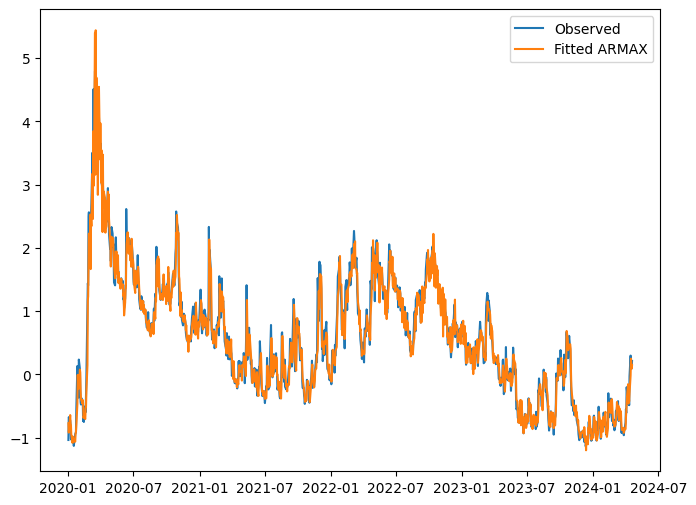

In [224]:
figure(figsize=(8, 6))
Y_test = Y[~train]
#print(Y_test)
plt.plot(Y_test, label='Observed')
plt.plot(idx, ARMAX.fittedvalues[~train],label='Fitted ARMAX')
plt.legend()
plt.show()

In [238]:
result = pd.DataFrame(
    {'RNN L1':[0.927],
     'LSTM L1':[0.929],
     'AR2': [0.945],
     'ARMAX': [0.963]},index = ['r2 score']
)

In [239]:
result

,RNN L1,LSTM L1,AR2,ARMAX
r2 score,0.927,0.929,0.945,0.963


# Conclusion

Using R2 score as the baseline score we observe that by fitting time series models such as SARMIX tend to achieve better goodness of fit compared to RNN/LSTM. One reason is that it is easier to optimize the SARMIX model by adjusting the lags since it is simplier to use.However, forecasting using time series models will be worse as compared to NN models.